# Лабораторная работа 2 Журавлев А.Д. ББМО-02-23

Задание 1

In [ ]:
!pip install adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.8 MB/s eta 0:00:00


Импорт бибилиотек

In [ ]:
import cv2
import os
import torch
import random
import pickle
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications import ResNet50
from keras.applications import VGG16
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.models import load_model, save_model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape, Lambda
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
%matplotlib inline

Загрузка данных

In [ ]:
import kagglehub

path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

100%|██████████| 612M/612M [00:28<00:00, 22.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


In [ ]:
data_path = path
train_data_path = os.path.join(data_path, 'Train')
test_data_path = os.path.join(data_path, 'Test')
meta_data_path = os.path.join(data_path, 'Meta')

Чтение тренировочного набора данных

In [ ]:
data = []
labels = []
class_count = 43
for i in range(class_count):
    img_path = os.path.join(train_data_path, str(i))
    for img in os.listdir(img_path):
        img = image.load_img(img_path + '/' + img, target_size=(32, 32))
        img_array = image.img_to_array(img)
        img_array = img_array / 255
        data.append(img_array)
        labels.append(i)
data = np.array(data)
labels = np.array(labels)
labels = to_categorical(labels, 43)
print("data[0]:\n",data[0])

data[0]:
 [[[0.07058824 0.07843138 0.07450981]
  [0.07450981 0.08235294 0.07843138]
  [0.09019608 0.10196079 0.10980392]
  ...
  [0.08627451 0.09019608 0.09019608]
  [0.07058824 0.07843138 0.07843138]
  [0.06666667 0.07058824 0.07058824]]

 [[0.08235294 0.08235294 0.07450981]
  [0.14901961 0.1254902  0.10980392]
  [0.22352941 0.17254902 0.1764706 ]
  ...
  [0.12156863 0.10980392 0.11372549]
  [0.11764706 0.10980392 0.10980392]
  [0.10196079 0.09411765 0.09019608]]

 [[0.11372549 0.10588235 0.10588235]
  [0.25490198 0.19215687 0.19607843]
  [0.3647059  0.24705882 0.23921569]
  ...
  [0.19607843 0.16470589 0.16470589]
  [0.1882353  0.16078432 0.17254902]
  [0.1764706  0.15686275 0.18039216]]

 ...

 [[0.33333334 0.30980393 0.30588236]
  [0.5568628  0.48235294 0.47058824]
  [0.78039217 0.654902   0.63529414]
  ...
  [0.4627451  0.47843137 0.47843137]
  [0.5647059  0.5058824  0.49019608]
  [0.40784314 0.36862746 0.3372549 ]]

 [[0.33333334 0.30980393 0.29803923]
  [0.5764706  0.49411765 0.

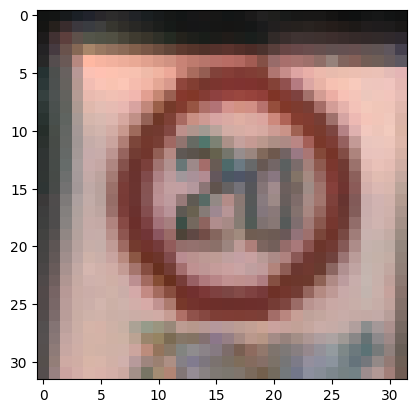

In [ ]:
plt.imshow(data[0])

Разделение данных на тестовый и тренировочный наборы

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.3, random_state=1)
print("training shape: ",x_train.shape, y_train.shape)
print("testing shape: ",x_val.shape, y_val.shape)
print(y_train[0])

training shape:  (27446, 32, 32, 3) (27446, 43)
testing shape:  (11763, 32, 32, 3) (11763, 43)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
model = Sequential()
model.add(ResNet50(include_top = False, pooling = 'avg'))
model.add(Dropout(0.1))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(43, activation = 'softmax'))
model.layers[2].trainable = False
print(model.summary())

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,123,307 (92.02 MB)

 Trainable params: 23,545,643 (89.82 MB)

 Non-trainable params: 577,664 (2.20 MB)

None


Обучение модели

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data =(x_val, y_val), epochs = 5, batch_size = 64)

Epoch 1/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 132s 138ms/step - accuracy: 0.5007 - loss: 1.9721 - val_accuracy: 0.2901 - val_loss: 2.8279
Epoch 2/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 70s 47ms/step - accuracy: 0.9290 - loss: 0.2634 - val_accuracy: 0.7489 - val_loss: 1.0405
Epoch 3/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.9678 - loss: 0.1131 - val_accuracy: 0.9496 - val_loss: 0.1727
Epoch 4/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9739 - loss: 0.1011 - val_accuracy: 0.9028 - val_loss: 1.8695
Epoch 5/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - accuracy: 0.9746 - loss: 0.1003 - val_accuracy: 0.9539 - val_loss: 0.1654


In [ ]:
save_model(model, 'ResNet50.h5')

In [ ]:
test = pd.read_csv("Test.csv")
test_imgs = test['Path'].values
data = []

for img in test_imgs:
    img = image.load_img(img, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = img_array / 255
    data.append(img_array)

data = np.array(data)
y_test = test['ClassId'].values.tolist()
y_test = np.array(y_test)
y_test = to_categorical(y_test, 43)

Модель для классификации изображений

In [ ]:
model2 = Sequential()
model2.add(VGG16(include_top=False, pooling = 'avg'))
model2.add(Dropout(0.1))
model2.add(Dense(256, activation="relu"))
model2.add(Dropout(0.1))
model2.add(Dense(43, activation = 'softmax'))
model2.layers[2].trainable = False
print(model2.summary())

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 512)                 │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,857,067 (56.68 MB)

 Trainable params: 14,725,739 (56.17 MB)

 Non-trainable params: 131,328 (513.00 KB)

None


Обучение модели

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
history2 = model2.fit(x_train, y_train, validation_data =(x_val, y_val), epochs = 5, batch_size = 64)

Epoch 1/5
429/429 [==============================] - 28s 49ms/step - loss: 3.2036 - accuracy: 0.1161 - val_loss: 2.0396 - val_accuracy: 0.3183
Epoch 2/5
429/429 [==============================] - 17s 40ms/step - loss: 1.1366 - accuracy: 0.6176 - val_loss: 0.5541 - val_accuracy: 0.8053
Epoch 3/5
429/429 [==============================] - 17s 40ms/step - loss: 0.3636 - accuracy: 0.8740 - val_loss: 0.2725 - val_accuracy: 0.9174
Epoch 4/5
429/429 [==============================] - 19s 43ms/step - loss: 0.1799 - accuracy: 0.9497 - val_loss: 0.1737 - val_accuracy: 0.9572
Epoch 5/5
429/429 [==============================] - 18s 41ms/step - loss: 0.1107 - accuracy: 0.9723 - val_loss: 0.0923 - val_accuracy: 0.9759


In [ ]:
save_model(model2, 'VGG16.h5')

<ipython-input-15-19742678d690>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model2, 'VGG16.h5')


# Выполним оценку производительности дыух моделей на тестовом наборе данных

In [ ]:
historyT1 = model.fit(x_val, y_val, epochs=5, batch_size=64, validation_data=(x_val, y_val))
historyT2 = model2.fit(x_val, y_val, epochs=5, batch_size=64, validation_data=(x_val, y_val))

Epoch 1/5
184/184 [==============================] - 13s 72ms/step - loss: 0.1274 - accuracy: 0.9687 - val_loss: 0.1082 - val_accuracy: 0.9700
Epoch 2/5
184/184 [==============================] - 10s 56ms/step - loss: 0.0863 - accuracy: 0.9790 - val_loss: 0.0856 - val_accuracy: 0.9757
Epoch 3/5
184/184 [==============================] - 11s 62ms/step - loss: 0.0448 - accuracy: 0.9886 - val_loss: 0.1389 - val_accuracy: 0.9621
Epoch 4/5
184/184 [==============================] - 12s 65ms/step - loss: 0.0569 - accuracy: 0.9862 - val_loss: 0.0222 - val_accuracy: 0.9935
Epoch 5/5
184/184 [==============================] - 12s 65ms/step - loss: 0.0322 - accuracy: 0.9919 - val_loss: 0.0554 - val_accuracy: 0.9878
Epoch 1/5
184/184 [==============================] - 11s 60ms/step - loss: 0.1239 - accuracy: 0.9690 - val_loss: 0.1064 - val_accuracy: 0.9714
Epoch 2/5
184/184 [==============================] - 9s 50ms/step - loss: 0.1893 - accuracy: 0.9613 - val_loss: 0.1196 - val_accuracy: 0.9700


# Создаем и выводим таблицу, которая показывает точность обоих моделей на треннировочном, валидационном и тестовом наборе данных

In [ ]:
from tabulate import tabulate

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
test_accuracy = historyT1.history['accuracy']

train_accuracy2 = historyT2.history['accuracy']
val_accuracy2 = historyT2.history['val_accuracy']
test_accuracy2 = historyT2.history['accuracy']

table = [["Model","Training Accuracy","Validation Accuracy","Test Accuracy"],
            ["Resnet50",train_accuracy[4]*100,val_accuracy[4]*100,test_accuracy[4]*100],
            ["VGG16",train_accuracy2[4]*100,val_accuracy2[4]*100,test_accuracy2[4]*100]]

table1 = tabulate(table,headers="firstrow",tablefmt="grid")
print(table1)

+----------+---------------------+-----------------------+-----------------+
| Model    |   Training Accuracy |   Validation Accuracy |   Test Accuracy |
+==========+=====================+=======================+=================+
| Resnet50 |             97.9961 |               94.2107 |         99.1924 |
+----------+---------------------+-----------------------+-----------------+
| VGG16    |             98.6568 |               99.4219 |         98.6568 |
+----------+---------------------+-----------------------+-----------------+


Графики процесса обучения модели ResNet50

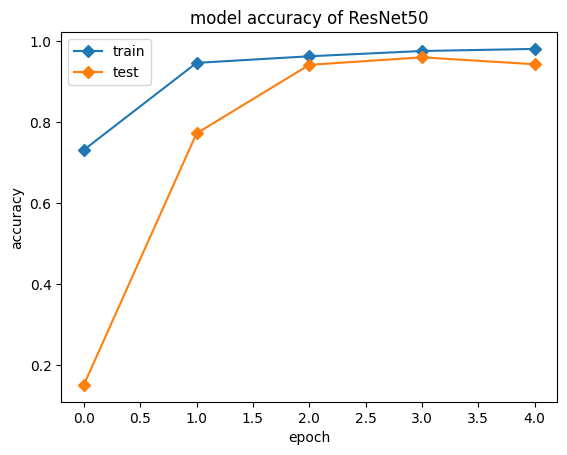

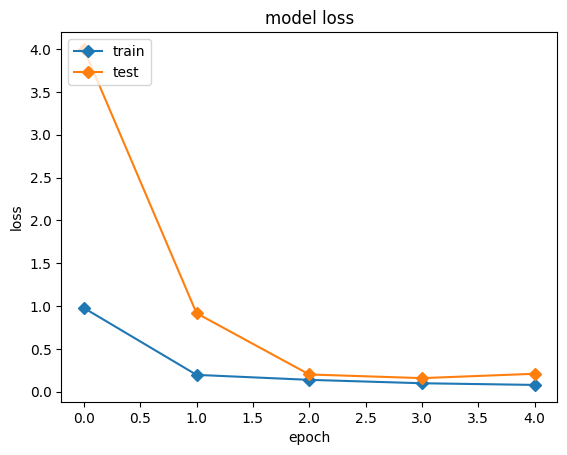

In [ ]:
plt.plot(history.history['accuracy'], marker='D')
plt.plot(history.history['val_accuracy'], marker='D')
plt.title('model accuracy of ResNet50')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'], marker='D')
plt.plot(history.history['val_loss'], marker='D')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Графики обучения модели VGG16

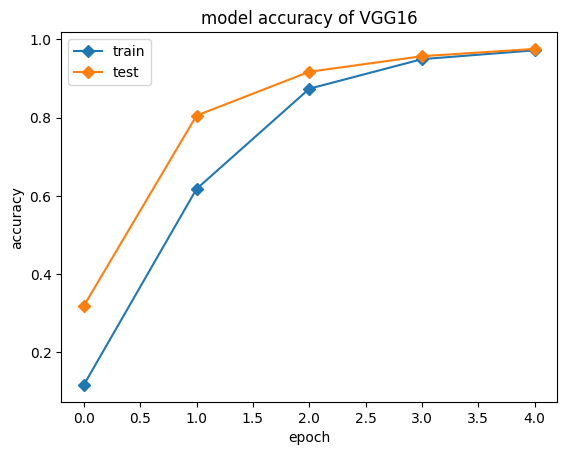

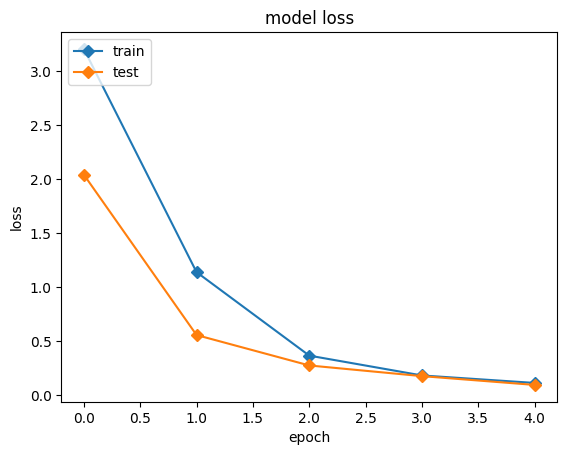

In [ ]:
plt.plot(history2.history['accuracy'], marker='D')
plt.plot(history2.history['val_accuracy'], marker='D')
plt.title('model accuracy of VGG16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history2.history['loss'], marker='D')
plt.plot(history2.history['val_loss'], marker='D')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Задание 2

In [ ]:
tf.compat.v1.disable_eager_execution()
model=load_model('ResNet50.h5')
x_test = data[:1000]
y_test = y_test[:1000]
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))

Instructions for updating:
Colocations handled automatically by placer.


Атака FGSM

In [ ]:

attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.3)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = []
adv_accuracises_fgsm = []
true_losses = []
adv_losses_fgsm = []

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_fgsm.append(accuracy)
    adv_losses_fgsm.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Adv Loss: 1.9394104208946228
Adv Accuracy: 0.671999990940094
True Loss: 0.5380555915161968
True Accuracy: 0.8769999742507935
Eps: 0.00784313725490196
Adv Loss: 3.2470588941574094
Adv Accuracy: 0.5019999742507935
True Loss: 0.5380555915161968
True Accuracy: 0.8769999742507935
Eps: 0.011764705882352941
Adv Loss: 4.28182907295227
Adv Accuracy: 0.382999986410141
True Loss: 0.5380555915161968
True Accuracy: 0.8769999742507935
Eps: 0.01568627450980392
Adv Loss: 5.106251237869262
Adv Accuracy: 0.30000001192092896
True Loss: 0.5380555915161968
True Accuracy: 0.8769999742507935
Eps: 0.0196078431372549
Adv Loss: 5.7425214920043945
Adv Accuracy: 0.24400000274181366
True Loss: 0.5380555915161968
True Accuracy: 0.8769999742507935
Eps: 0.03137254901960784
Adv Loss: 6.809042762756348
Adv Accuracy: 0.1589999943971634
True Loss: 0.5380555915161968
True Accuracy: 0.8769999742507935
Eps: 0.0392156862745098
Adv Loss: 7.213692790985108
Adv Accuracy: 0.12200000137090683
True Loss: 0.5380555915161968
True Ac

In [ ]:
adv_losses_fgsm = np.array(adv_losses_fgsm)
adv_accuracises_fgsm = np.array(adv_accuracises_fgsm)
np.save("adv_losses_fgsm_ResNet50", adv_losses_fgsm)
np.save("adv_accuracises_fgsm_ResNet50", adv_accuracises_fgsm)

Исходные и атакованные изображения для разных eps

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


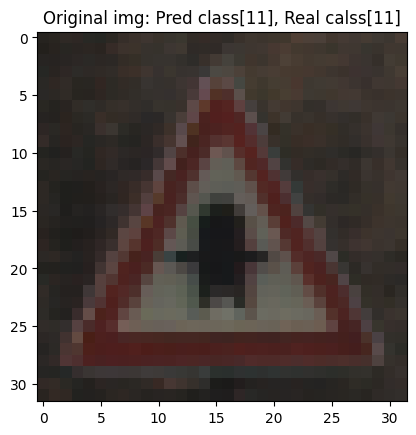

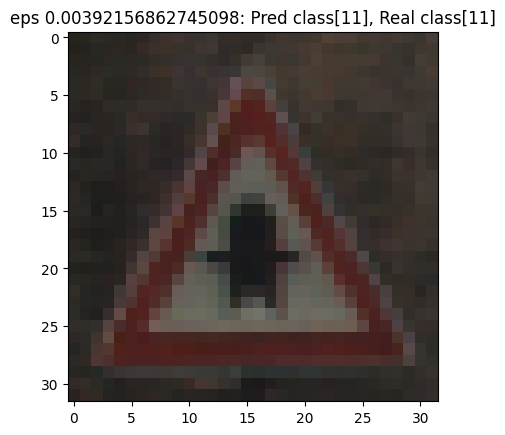

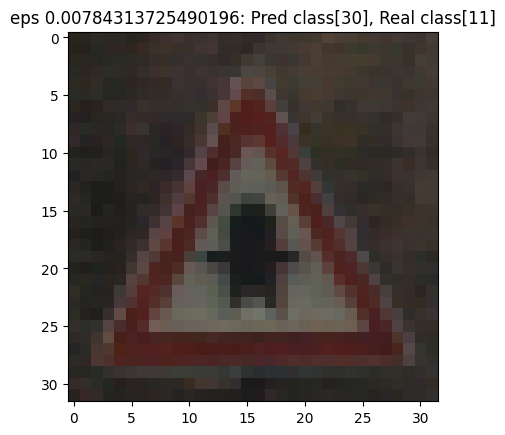

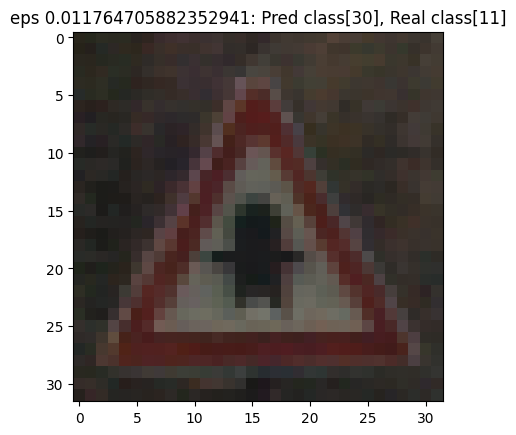

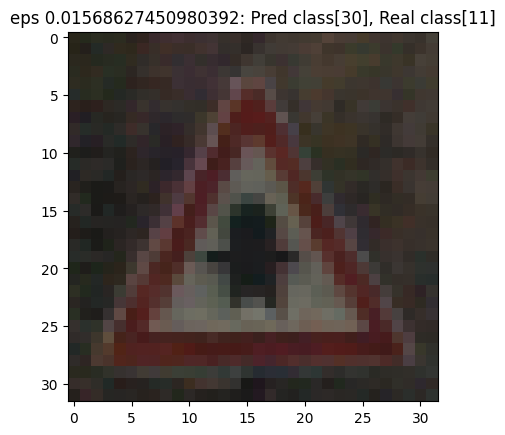

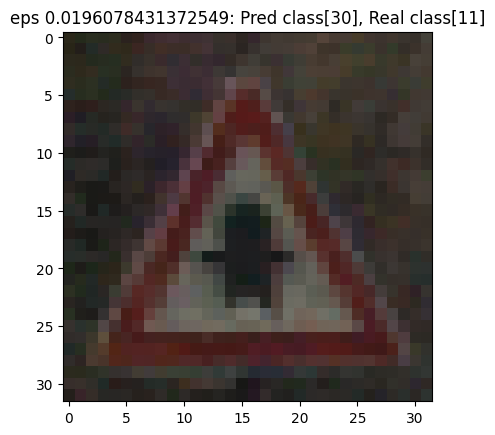

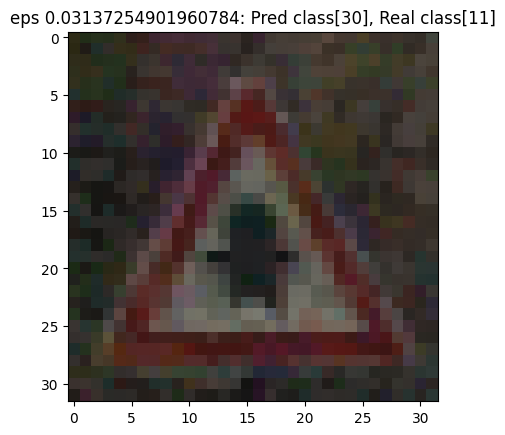

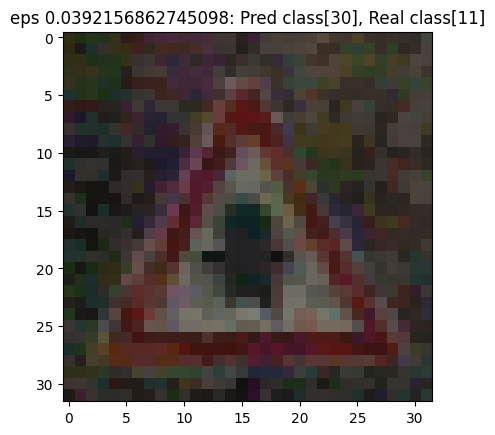

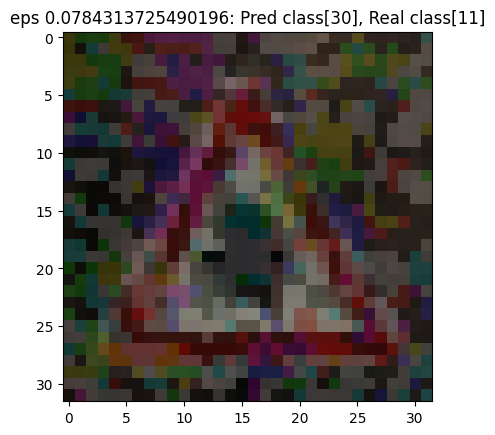

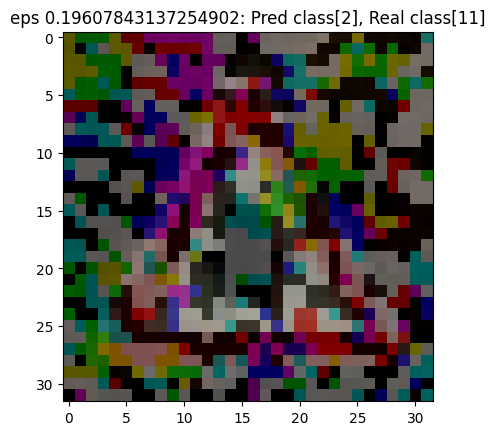

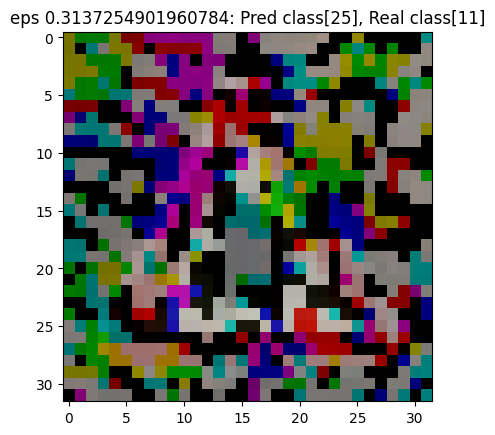

In [ ]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(4)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1


for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1

In [ ]:
tf.compat.v1.disable_eager_execution()
model=load_model('ResNet50.h5')
x_test = data[:1000]
y_test = y_test[:1000]
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))

Атака PGD

In [ ]:
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = []
adv_accuracises_pgd = []
true_losses = []
adv_losses_pgd = []

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_pgd.append(accuracy)
    adv_losses_pgd.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
Adv Loss: 2.293233123779297
Adv Accuracy: 0.6520000100135803
True Loss: 0.5380555915161968
True Accuracy: 0.8769999742507935
Eps: 0.00784313725490196
Adv Loss: 3.8862324466705322
Adv Accuracy: 0.4580000042915344
True Loss: 0.5380555915161968
True Accuracy: 0.8769999742507935
Eps: 0.011764705882352941
Adv Loss: 5.160812589645386
Adv Accuracy: 0.34599998593330383
True Loss: 0.5380555915161968
True Accuracy: 0.8769999742507935
Eps: 0.01568627450980392
Adv Loss: 5.974000137329101
Adv Accuracy: 0.2720000147819519
True Loss: 0.5380555915161968
True Accuracy: 0.8769999742507935
Eps: 0.0196078431372549
Adv Loss: 6.51011003112793
Adv Accuracy: 0.2370000034570694
True Loss: 0.5380555915161968
True Accuracy: 0.8769999742507935
Eps: 0.03137254901960784
Adv Loss: 7.380181282043457
Adv Accuracy: 0.19599999487400055
True Loss: 0.5380555915161968
True Accuracy: 0.8769999742507935
Eps: 0.0392156862745098
Adv Loss: 7.7493028030395505
Adv Accuracy: 0.1720000058412552
True Loss: 0

In [ ]:
adv_losses_pgd = np.array(adv_losses_pgd)
adv_accuracises_pgd = np.array(adv_accuracises_pgd)
np.save("adv_losses_pgd_ResNet50", adv_losses_pgd)
np.save("adv_accuracises_pgd_ResNet50", adv_accuracises_pgd)

Исходные и атакованные изображения для разных eps

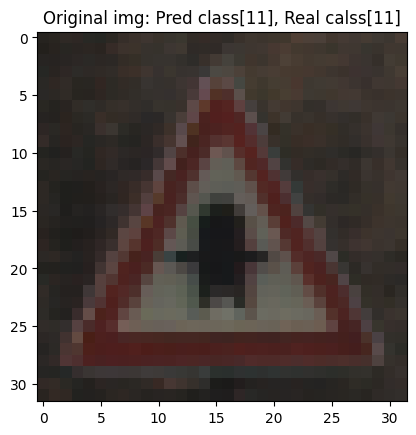

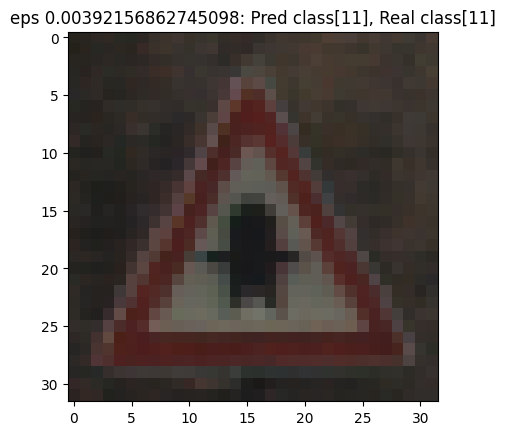

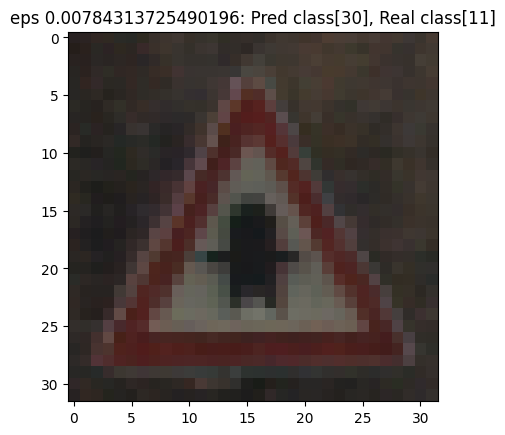

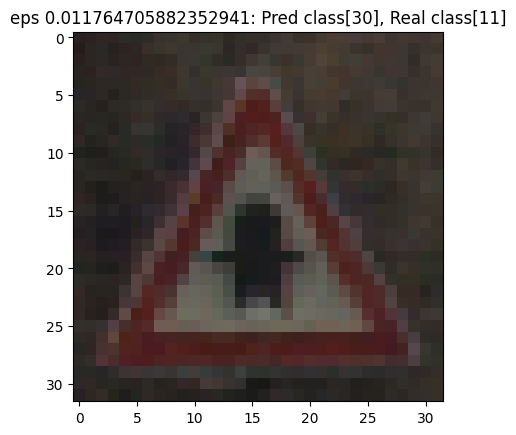

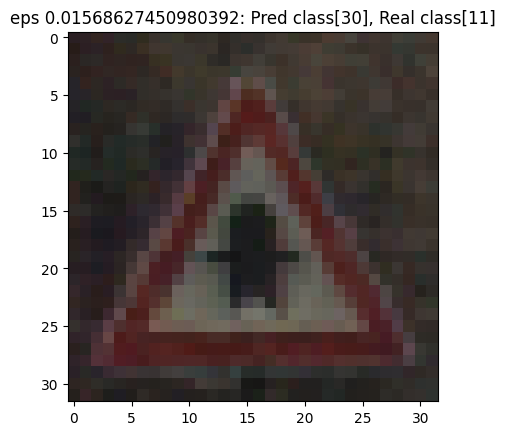

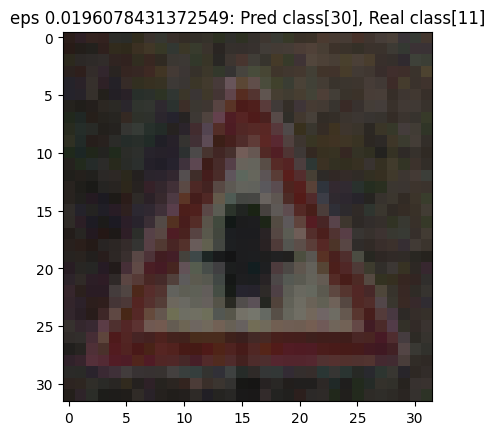

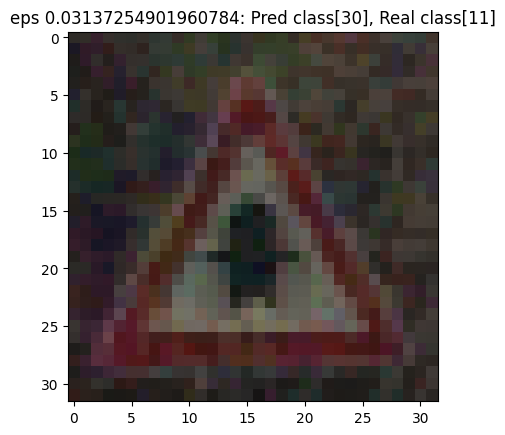

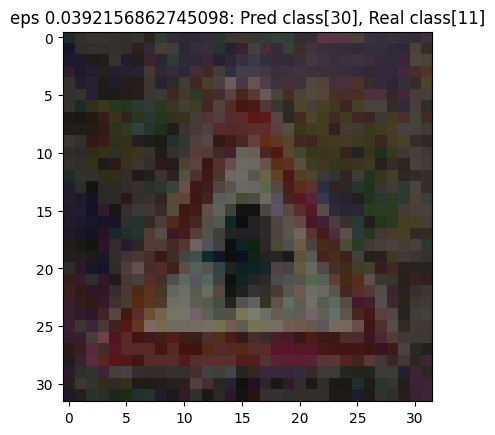

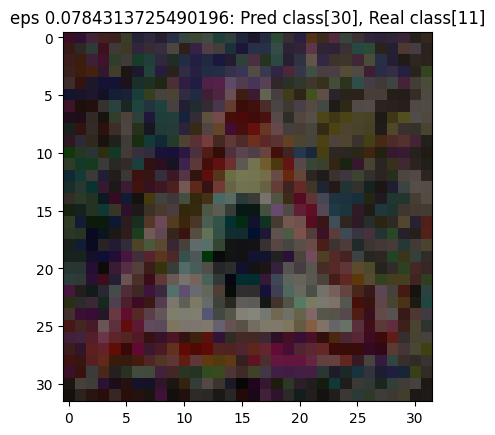

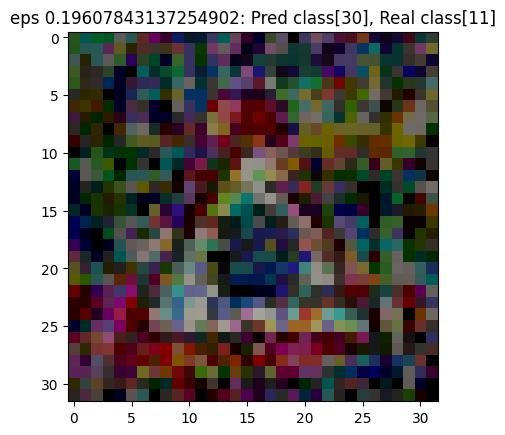

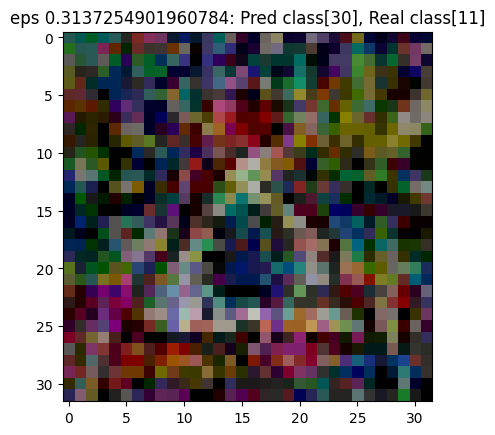

In [ ]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(4)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    x_test_adv = attack_pgd.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1

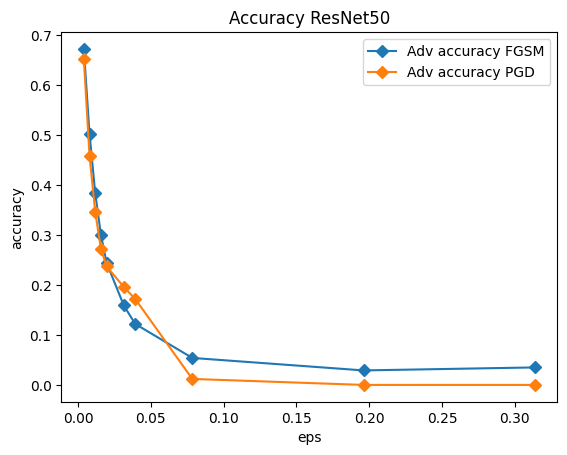

In [ ]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
adv_accuracises_fgsm = np.load("adv_accuracises_fgsm_ResNet50.npy")
adv_accuracises_pgd = np.load("adv_accuracises_pgd_ResNet50.npy")
plt.figure(0)
plt.plot(eps_range, adv_accuracises_fgsm, label="Adv accuracy FGSM", marker='D')
plt.plot(eps_range, adv_accuracises_pgd, label="Adv accuracy PGD", marker='D')
plt.title("Accuracy ResNet50")
plt.xlabel("eps")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [ ]:
tf.compat.v1.disable_eager_execution()
model=load_model('VGG16.h5')
x_test = data[:1000]
y_test = y_test[:1000]
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))

Атака FGSM для VGG16

In [ ]:
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.3)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = []
adv_accuracises_fgsm = []
true_losses = []
adv_losses_fgsm = []

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_fgsm.append(accuracy)
    adv_losses_fgsm.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
Adv Loss: 0.9212489709854126
Adv Accuracy: 0.8370000123977661
True Loss: 0.3079795994311571
True Accuracy: 0.9390000104904175
Eps: 0.00784313725490196
Adv Loss: 1.6173949222564696
Adv Accuracy: 0.7390000224113464
True Loss: 0.3079795994311571
True Accuracy: 0.9390000104904175
Eps: 0.011764705882352941
Adv Loss: 2.2263155937194825
Adv Accuracy: 0.6850000023841858
True Loss: 0.3079795994311571
True Accuracy: 0.9390000104904175
Eps: 0.01568627450980392
Adv Loss: 2.7041345148086546
Adv Accuracy: 0.6420000195503235
True Loss: 0.3079795994311571
True Accuracy: 0.9390000104904175
Eps: 0.0196078431372549
Adv Loss: 3.078448504447937
Adv Accuracy: 0.6129999756813049
True Loss: 0.3079795994311571
True Accuracy: 0.9390000104904175
Eps: 0.03137254901960784
Adv Loss: 3.841087484359741
Adv Accuracy: 0.5559999942779541
True Loss: 0.3079795994311571
True Accuracy: 0.9390000104904175
Eps: 0.0392156862745098
Adv Loss: 4.0826173696517944
Adv Accuracy: 0.5370000004768372
True Loss:

In [ ]:
adv_losses_fgsm = np.array(adv_losses_fgsm)
adv_accuracises_fgsm = np.array(adv_accuracises_fgsm)
np.save("adv_losses_fgsm_VGG16", adv_losses_fgsm)
np.save("adv_accuracises_fgsm_VGG16", adv_accuracises_fgsm)

Исходные и адверсариальные изображения для разных eps

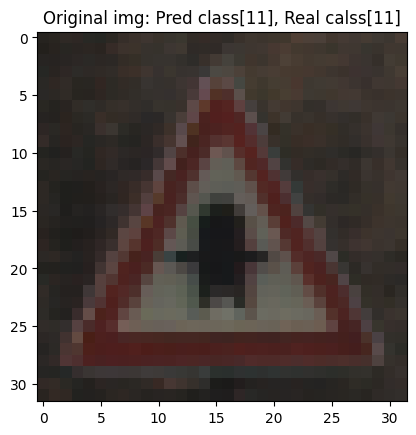

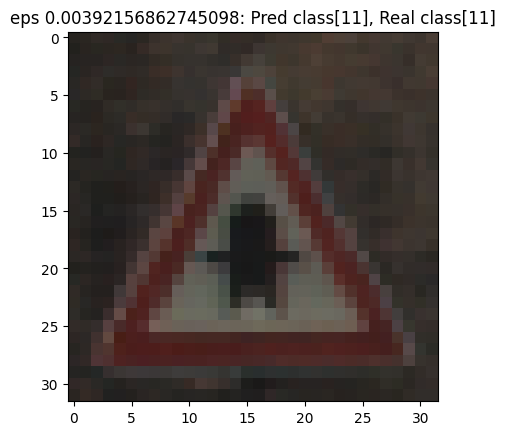

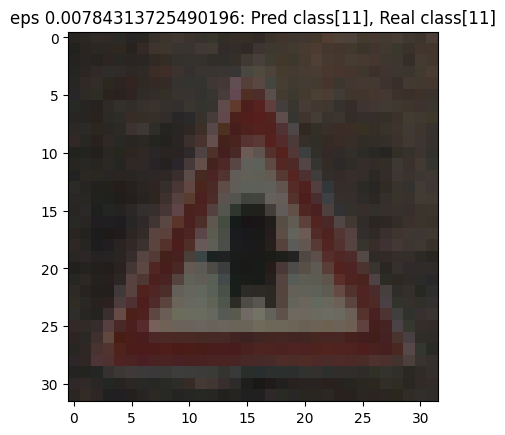

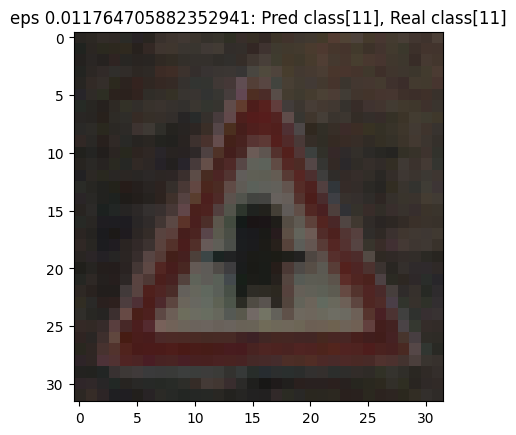

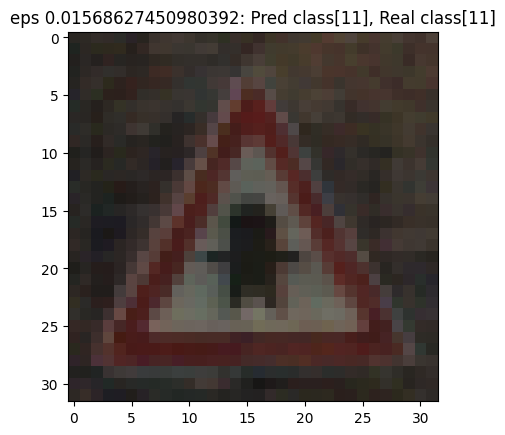

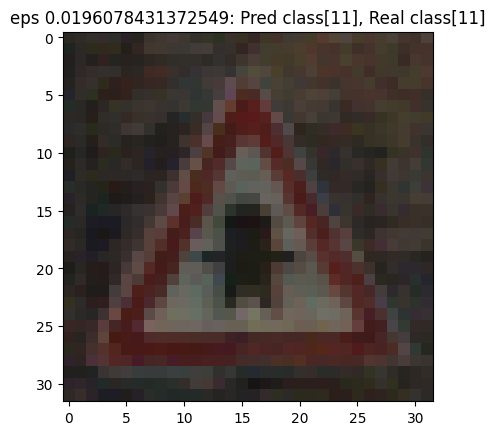

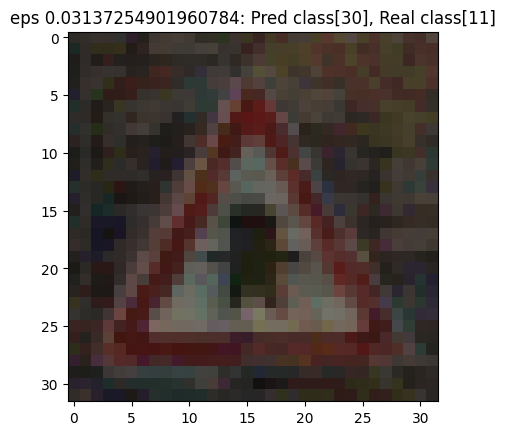

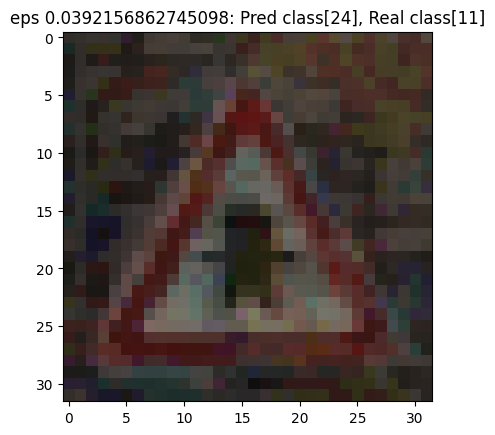

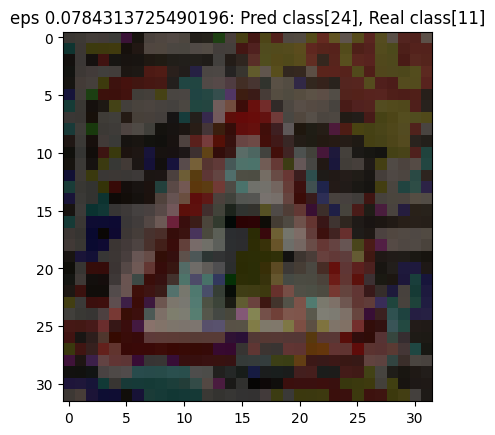

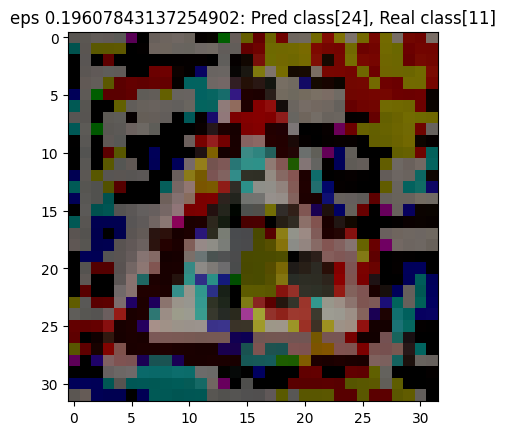

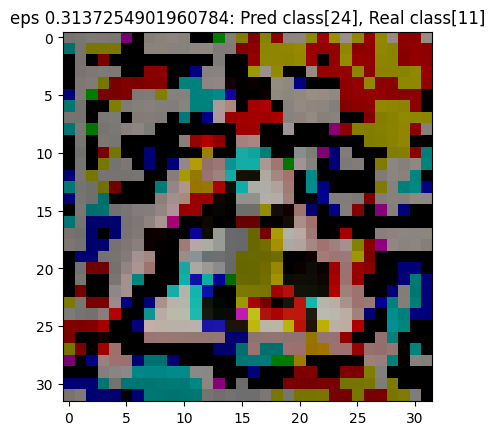

In [ ]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(0)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1

In [ ]:
tf.compat.v1.disable_eager_execution()
model=load_model('VGG16.h5')
x_test = data[:1000]
y_test = y_test[:1000]
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))

Атака PGD для VGG16

In [ ]:
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = []
adv_accuracises_pgd = []
true_losses = []
adv_losses_pgd = []

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_pgd.append(accuracy)
    adv_losses_pgd.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
Adv Loss: 1.104073203086853
Adv Accuracy: 0.8190000057220459
True Loss: 0.3079795994311571
True Accuracy: 0.9390000104904175
Eps: 0.00784313725490196
Adv Loss: 2.027790294647217
Adv Accuracy: 0.7210000157356262
True Loss: 0.3079795994311571
True Accuracy: 0.9390000104904175
Eps: 0.011764705882352941
Adv Loss: 2.7207693576812746
Adv Accuracy: 0.6819999814033508
True Loss: 0.3079795994311571
True Accuracy: 0.9390000104904175
Eps: 0.01568627450980392
Adv Loss: 3.1959559478759765
Adv Accuracy: 0.6549999713897705
True Loss: 0.3079795994311571
True Accuracy: 0.9390000104904175
Eps: 0.0196078431372549
Adv Loss: 3.6934689798355103
Adv Accuracy: 0.6119999885559082
True Loss: 0.3079795994311571
True Accuracy: 0.9390000104904175
Eps: 0.03137254901960784
Adv Loss: 5.279693963050843
Adv Accuracy: 0.5509999990463257
True Loss: 0.3079795994311571
True Accuracy: 0.9390000104904175
Eps: 0.0392156862745098
Adv Loss: 5.272981452941894
Adv Accuracy: 0.5410000085830688
True Loss: 0

In [ ]:
adv_losses_pgd = np.array(adv_losses_pgd)
adv_accuracises_pgd = np.array(adv_accuracises_pgd)
np.save("adv_losses_pgd_VGG16", adv_losses_pgd)
np.save("adv_accuracises_pgd_VGG16", adv_accuracises_pgd)

Исходные и адверсариальные изображения для разных значений eps

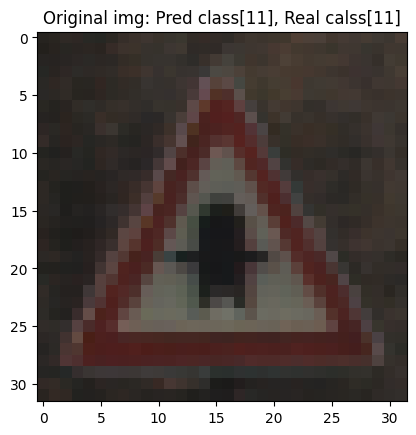

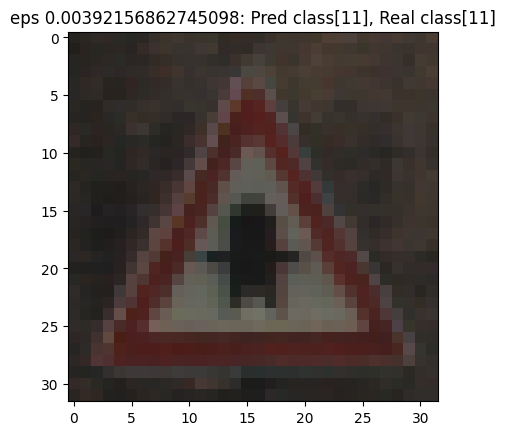

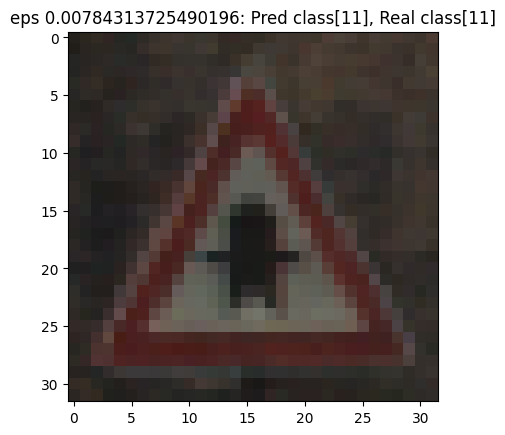

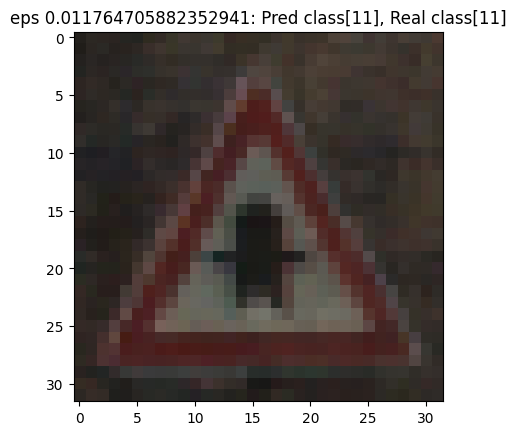

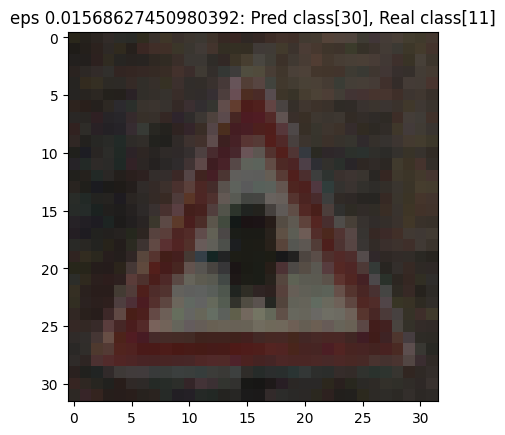

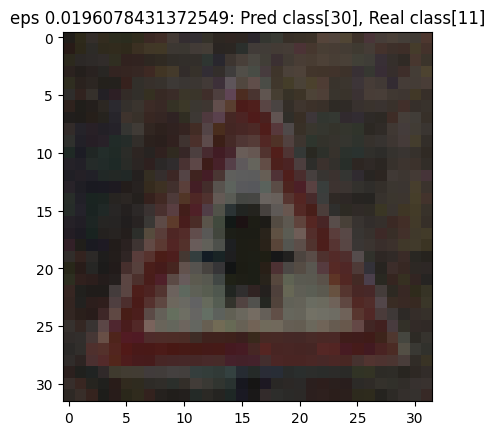

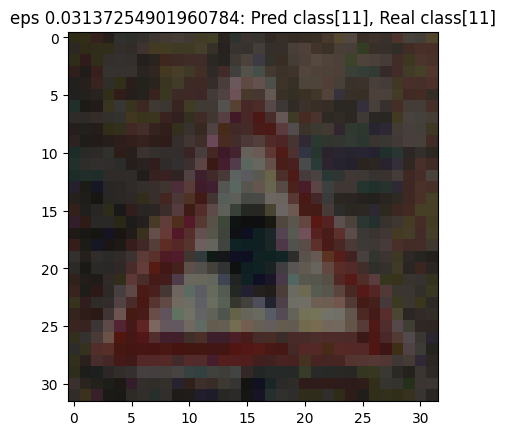

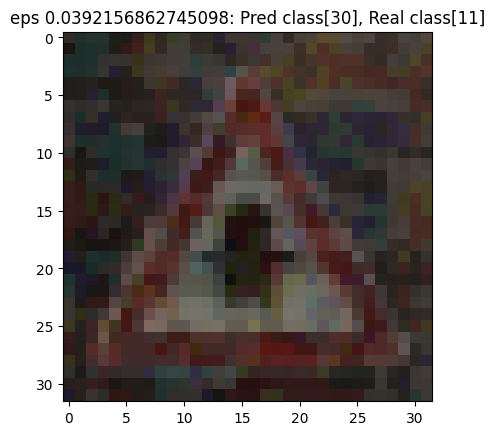

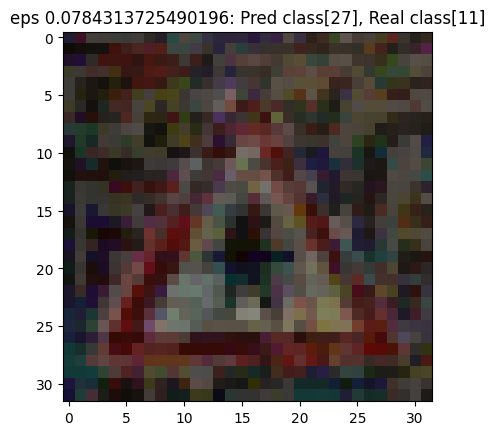

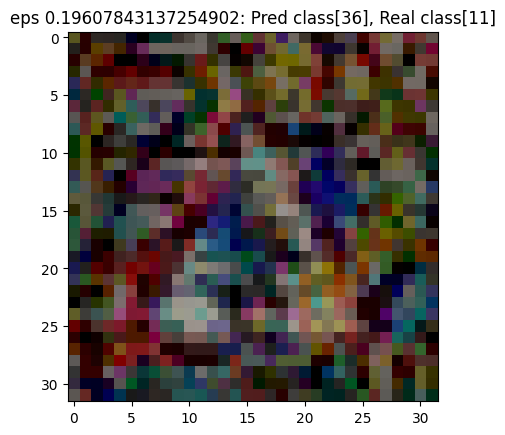

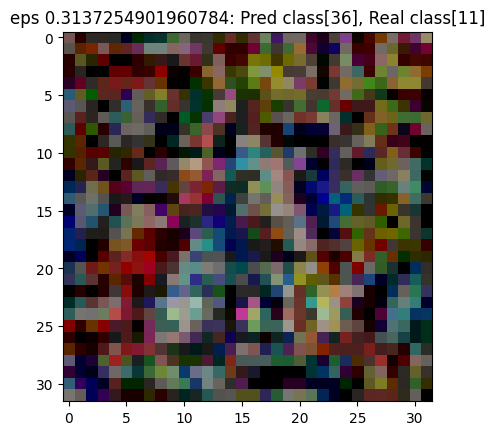

In [ ]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(0)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    x_test_adv = attack_pgd.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1

Загрузка массива адвирсариальных точностей для атак FGSM и PGD

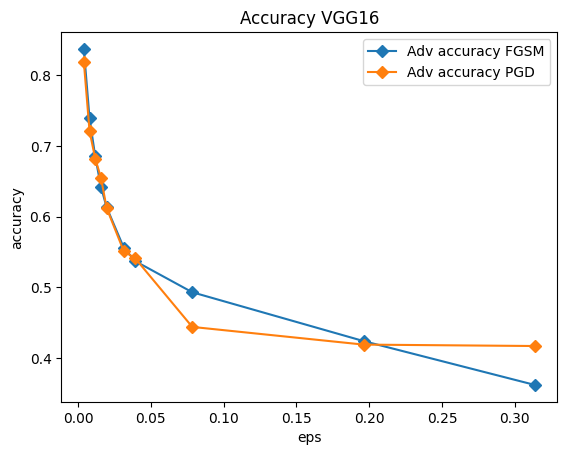

In [ ]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]

adv_accuracises_fgsm = np.load("adv_accuracises_fgsm_VGG16.npy")
adv_accuracises_pgd = np.load("adv_accuracises_pgd_VGG16.npy")
plt.figure(0)
plt.plot(eps_range, adv_accuracises_fgsm, label="Adv accuracy FGSM", marker='D')
plt.plot(eps_range, adv_accuracises_pgd, label="Adv accuracy PGD", marker='D')
plt.title("Accuracy VGG16")
plt.xlabel("eps")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [ ]:
adv_acc_fgsm_rn50 = np.load("adv_accuracises_fgsm_ResNet50.npy")
adv_acc_pgd_rn50 = np.load("adv_accuracises_pgd_ResNet50.npy")
adv_acc_fgsm_v16 = np.load("adv_accuracises_fgsm_VGG16.npy")
adv_acc_pgd_v16 = np.load("adv_accuracises_pgd_VGG16.npy")

table = [["Model","Original accuracy","eps = 1/255","eps = 2/255", "eps = 3/255", "eps = 4/255", "eps = 5/255", "eps = 8/255", "eps = 10/255", "eps = 20/255", "eps = 50/255", "eps = 80/255" ],
            ["Resnet50 FGSM",train_accuracy[4]*100,adv_acc_fgsm_rn50[0]*100,
             adv_acc_fgsm_rn50[1]*100,adv_acc_fgsm_rn50[2]*100,adv_acc_fgsm_rn50[3]*100,
             adv_acc_fgsm_rn50[4]*100,adv_acc_fgsm_rn50[5]*100,adv_acc_fgsm_rn50[6]*100,
             adv_acc_fgsm_rn50[7]*100,adv_acc_fgsm_rn50[8]*100,adv_acc_fgsm_rn50[9]*100],
            ["Resnet50 PGD",train_accuracy[4]*100,adv_acc_pgd_rn50[0]*100,
             adv_acc_pgd_rn50[1]*100,adv_acc_pgd_rn50[2]*100,adv_acc_pgd_rn50[3]*100,
             adv_acc_pgd_rn50[4]*100,adv_acc_pgd_rn50[5]*100,adv_acc_pgd_rn50[6]*100,
             adv_acc_pgd_rn50[7]*100,adv_acc_pgd_rn50[8]*100,adv_acc_pgd_rn50[9]*100],
            ["VGG16 FGSM",train_accuracy2[4]*100,adv_acc_fgsm_v16[0]*100,
             adv_acc_fgsm_v16[1]*100,adv_acc_fgsm_v16[2]*100,adv_acc_fgsm_v16[3]*100,
             adv_acc_fgsm_v16[4]*100,adv_acc_fgsm_v16[5]*100,adv_acc_fgsm_v16[6]*100,
             adv_acc_fgsm_v16[7]*100,adv_acc_fgsm_v16[8]*100,adv_acc_fgsm_v16[9]*100],
            ["VGG16 PGD",train_accuracy2[4]*100,adv_acc_pgd_v16[0]*100,
             adv_acc_pgd_v16[1]*100,adv_acc_pgd_v16[2]*100,adv_acc_pgd_v16[3]*100,
             adv_acc_pgd_v16[4]*100,adv_acc_pgd_v16[5]*100,adv_acc_pgd_v16[6]*100,
             adv_acc_pgd_v16[7]*100,adv_acc_pgd_v16[8]*100,adv_acc_pgd_v16[9]*100],
         ]

table2 = tabulate(table,headers="firstrow",tablefmt="grid")
print(table2)

+---------------+---------------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+----------------+----------------+
| Model         |   Original accuracy |   eps = 1/255 |   eps = 2/255 |   eps = 3/255 |   eps = 4/255 |   eps = 5/255 |   eps = 8/255 |   eps = 10/255 |   eps = 20/255 |   eps = 50/255 |   eps = 80/255 |
+===============+=====================+===============+===============+===============+===============+===============+===============+================+================+================+================+
| Resnet50 FGSM |             97.9961 |          67.2 |          50.2 |          38.3 |          30   |          24.4 |          15.9 |           12.2 |            5.4 |            2.9 |            3.5 |
+---------------+---------------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+---------------

Задание 3

In [ ]:
test = pd.read_csv("Test.csv")
test_imgs = test['Path'].values
data = []
y_test = []
labels = test['ClassId'].values.tolist()
i = -1

for img in test_imgs:
    i += 1
    if labels[i] != 14:
      continue
    img = image.load_img(img, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = img_array /255
    data.append(img_array)
    y_test.append(labels[i])
data = np.array(data)
y_test = np.array(y_test)
y_test = to_categorical(y_test, 43)

Атака FGSM

In [ ]:
model=load_model('ResNet50.h5')
tf.compat.v1.disable_eager_execution()
t_class = 1
t_class = to_categorical(t_class, 43)
t_classes = np.tile(t_class, (270, 1))
x_test = data
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.2, targeted=True, batch_size=64)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, t_classes)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Adv Loss: 1.557951064904531
Adv Accuracy: 0.7888888716697693
True Loss: 0.4969181913468573
True Accuracy: 0.9259259104728699
Eps: 0.00784313725490196
Adv Loss: 3.868713295901263
Adv Accuracy: 0.5222222208976746
True Loss: 0.4969181913468573
True Accuracy: 0.9259259104728699
Eps: 0.011764705882352941
Adv Loss: 6.712968413035075
Adv Accuracy: 0.32592591643333435
True Loss: 0.4969181913468573
True Accuracy: 0.9259259104728699
Eps: 0.01568627450980392
Adv Loss: 9.416249296400283
Adv Accuracy: 0.2074074000120163
True Loss: 0.4969181913468573
True Accuracy: 0.9259259104728699
Eps: 0.0196078431372549
Adv Loss: 11.49606736501058
Adv Accuracy: 0.15555556118488312
True Loss: 0.4969181913468573
True Accuracy: 0.9259259104728699
Eps: 0.03137254901960784
Adv Loss: 14.811771555300112
Adv Accuracy: 0.08888889104127884
True Loss: 0.4969181913468573
True Accuracy: 0.9259259104728699
Eps: 0.0392156862745098
Adv Loss: 15.681340104562265
Adv Accuracy: 0.07407407462596893
True Loss: 0.4969181913468573
True

In [ ]:
eps = 10/255
attack_fgsm.set_params(**{'eps': eps})
x_test_adv = attack_fgsm.generate(x_test, t_classes)

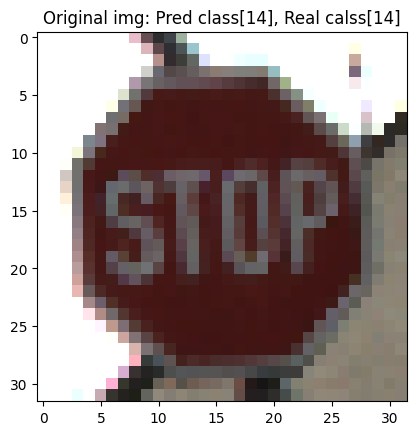

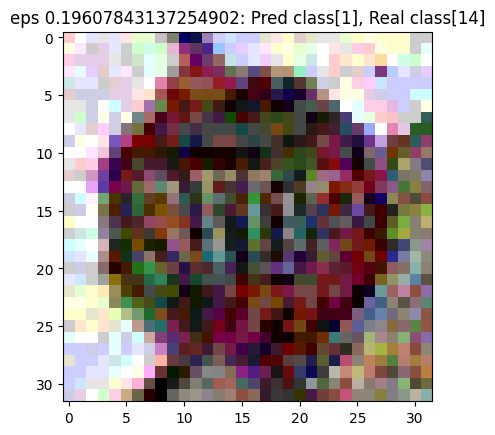

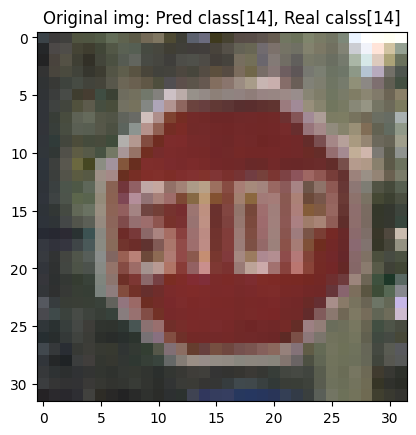

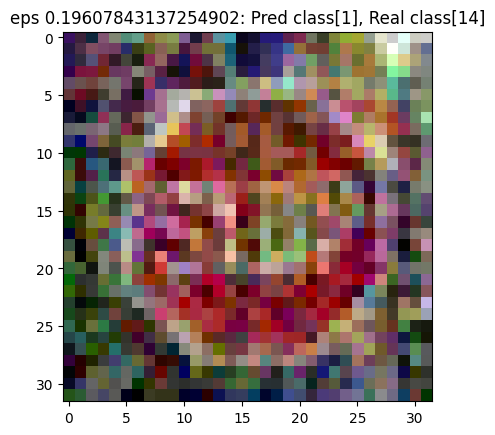

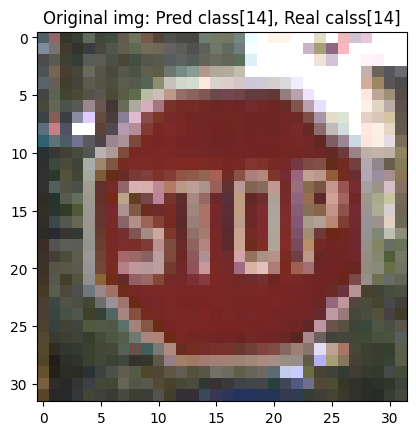

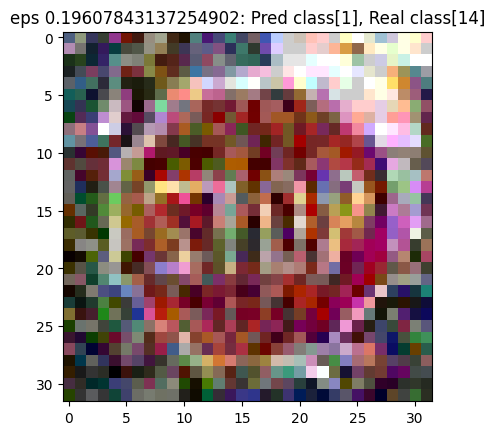

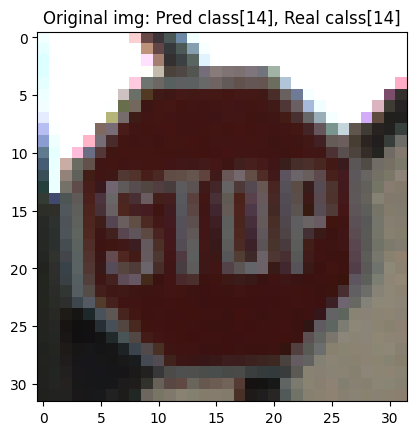

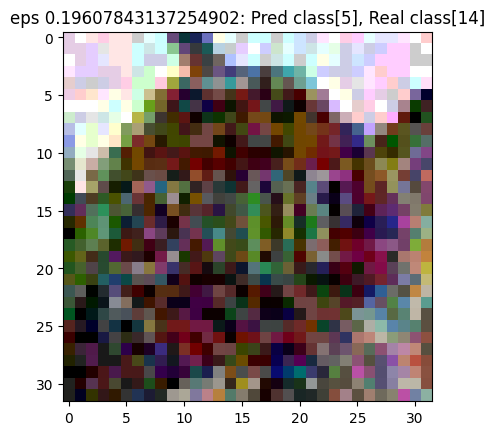

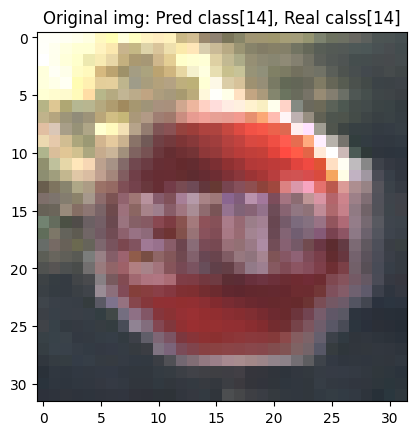

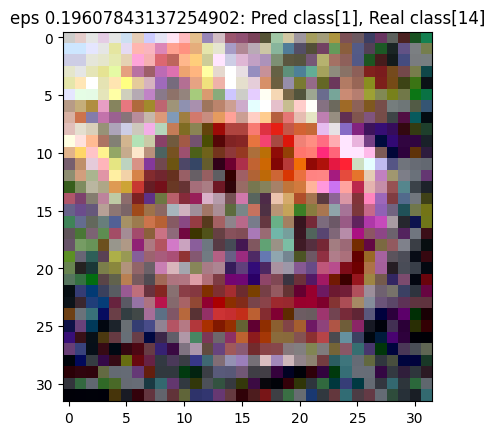

In [ ]:
range = [0, 10, 20, 30, 40]
i = 0
for index in range:
  plt.figure(i)
  pred = np.argmax(model.predict(x_test[index:index+1]))
  plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[index])}]")
  plt.imshow(x_test[index])
  plt.show()
  i += 1
  pred = np.argmax(model.predict(x_test_adv[index:index+1]))
  plt.figure(i)
  plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[index])}]")
  plt.imshow(x_test_adv[index])
  plt.show()

Атака PGD

In [ ]:
model=load_model('ResNet50.h5')
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False, targeted=True)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, t_classes)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Adv Loss: 1.0323372222759106
Adv Accuracy: 0.8703703880310059
True Loss: 0.4969181913468573
True Accuracy: 0.9259259104728699
Eps: 0.00784313725490196
Adv Loss: 2.495739804373847
Adv Accuracy: 0.7037037014961243
True Loss: 0.4969181913468573
True Accuracy: 0.9259259104728699
Eps: 0.011764705882352941
Adv Loss: 4.342311235710427
Adv Accuracy: 0.5481481552124023
True Loss: 0.4969181913468573
True Accuracy: 0.9259259104728699
Eps: 0.01568627450980392
Adv Loss: 5.50564451570864
Adv Accuracy: 0.4888888895511627
True Loss: 0.4969181913468573
True Accuracy: 0.9259259104728699
Eps: 0.0196078431372549
Adv Loss: 6.288722084186695
Adv Accuracy: 0.48148149251937866
True Loss: 0.4969181913468573
True Accuracy: 0.9259259104728699
Eps: 0.03137254901960784
Adv Loss: 9.170144586209897
Adv Accuracy: 0.36666667461395264
True Loss: 0.4969181913468573
True Accuracy: 0.9259259104728699
Eps: 0.0392156862745098
Adv Loss: 9.639045623496727
Adv Accuracy: 0.3481481373310089
True Loss: 0.4969181913468573
True Acc

In [ ]:
eps = 10/255
attack_pgd.set_params(**{'eps': eps})
x_test_adv = attack_pgd.generate(x_test, t_classes)

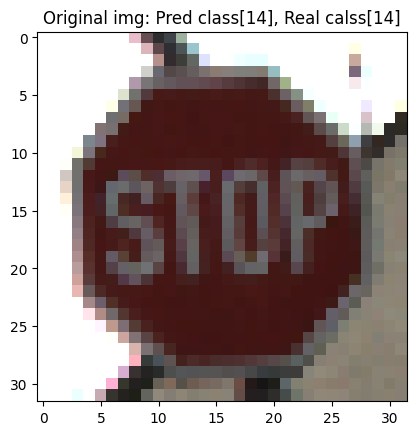

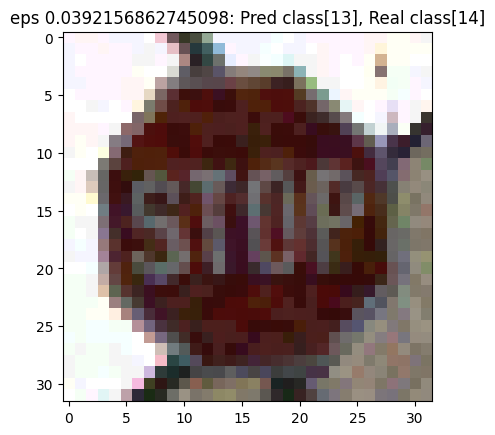

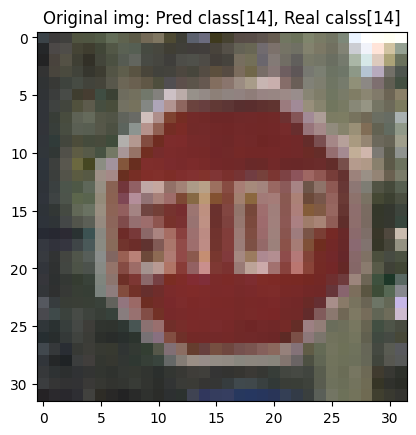

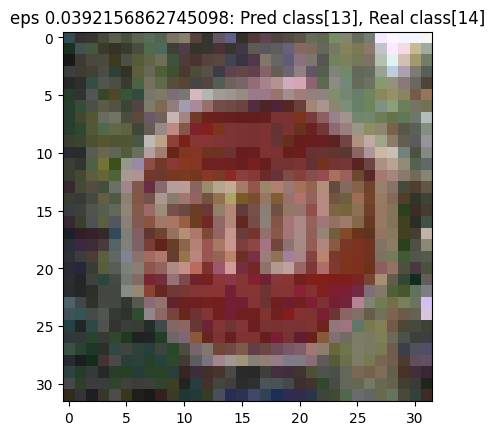

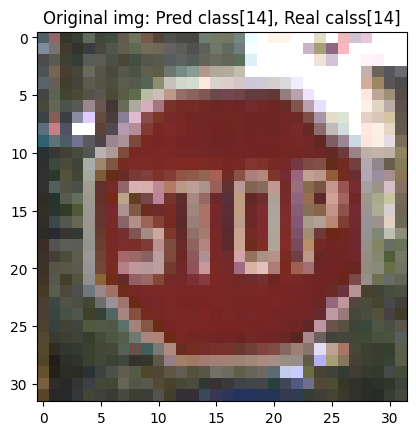

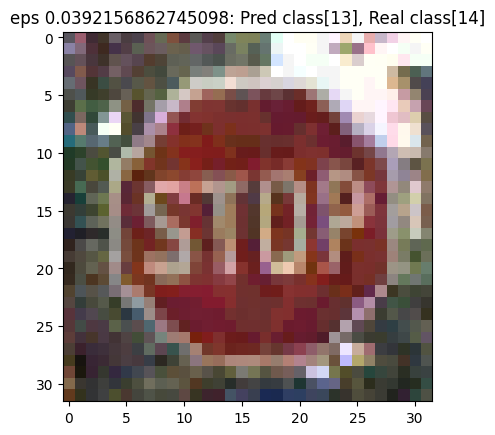

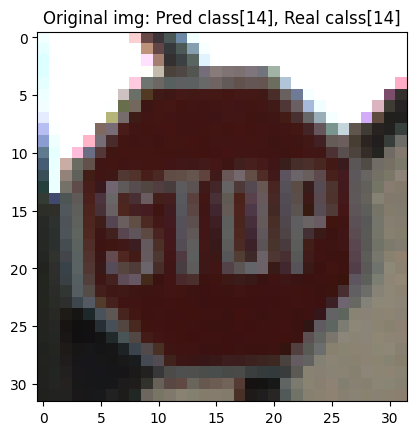

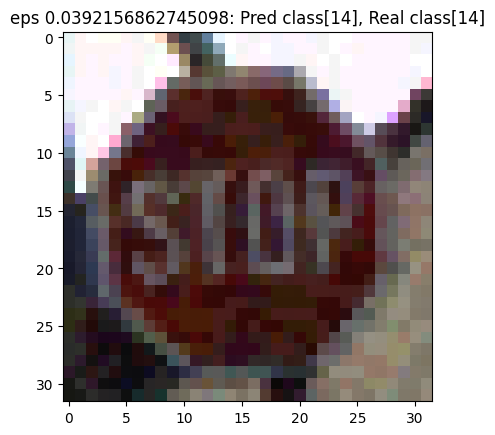

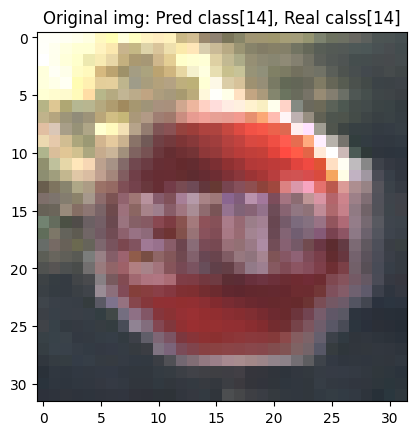

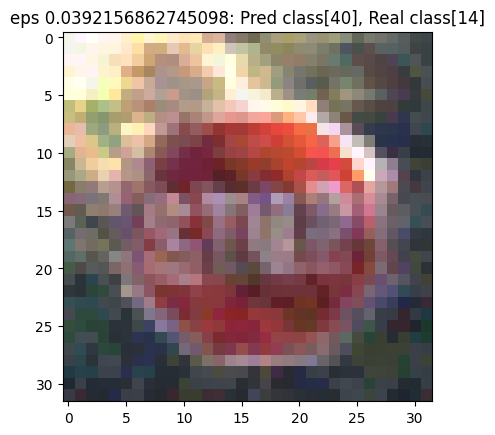

In [ ]:
range = [0, 10, 20, 30, 40]
i = 0
for index in range:
  plt.figure(i)
  pred = np.argmax(model.predict(x_test[index:index+1]))
  plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[index])}]")
  plt.imshow(x_test[index])
  plt.show()
  i += 1
  pred = np.argmax(model.predict(x_test_adv[index:index+1]))
  plt.figure(i)
  plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[index])}]")
  plt.imshow(x_test_adv[index])
  plt.show()